In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet

# Dataset

In [2]:
btc = yf.Ticker('BTC-USD')
ltc = yf.Ticker('LTC-USD')
eth = yf.Ticker('ETH-USD')

btc_hist = btc.history(period='max')
ltc_hist = ltc.history(period='max')
eth_hist = eth.history(period='max')

In [3]:
btc_hist.to_csv('bitcoin_history.csv', index=True)
ltc_hist.to_csv('litcoin_history.csv', index=True)
eth_hist.to_csv('ethereun_history.csv', index=True)

# EDA

In [3]:
eth_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0


In [4]:
btc_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [23]:
ltc_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,5.08589,5.17077,4.96595,5.05855,3071840,0.0,0.0
2014-09-18 00:00:00+00:00,5.06543,5.06543,4.57996,4.68523,4569260,0.0,0.0
2014-09-19 00:00:00+00:00,4.68729,4.75582,4.25435,4.32777,3917450,0.0,0.0
2014-09-20 00:00:00+00:00,4.32920,4.61608,4.20219,4.28644,5490660,0.0,0.0
2014-09-21 00:00:00+00:00,4.26307,4.30013,4.15499,4.24592,2931220,0.0,0.0


In [24]:
ltc_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3859 entries, 2014-09-17 00:00:00+00:00 to 2025-04-10 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3859 non-null   float64
 1   High          3859 non-null   float64
 2   Low           3859 non-null   float64
 3   Close         3859 non-null   float64
 4   Volume        3859 non-null   int64  
 5   Dividends     3859 non-null   float64
 6   Stock Splits  3859 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 241.2 KB


In [25]:
btc_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3859 entries, 2014-09-17 00:00:00+00:00 to 2025-04-10 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3859 non-null   float64
 1   High          3859 non-null   float64
 2   Low           3859 non-null   float64
 3   Close         3859 non-null   float64
 4   Volume        3859 non-null   int64  
 5   Dividends     3859 non-null   float64
 6   Stock Splits  3859 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 241.2 KB


In [26]:
eth_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2710 entries, 2017-11-09 00:00:00+00:00 to 2025-04-10 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2710 non-null   float64
 1   High          2710 non-null   float64
 2   Low           2710 non-null   float64
 3   Close         2710 non-null   float64
 4   Volume        2710 non-null   int64  
 5   Dividends     2710 non-null   float64
 6   Stock Splits  2710 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 169.4 KB


In [27]:
btc_hist.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [28]:
ltc_hist.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [29]:
eth_hist.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [20]:
btc_his_res = btc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
ltc_his_res = ltc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
eth_his_res = eth_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [21]:
btc_his_res.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100


In [22]:
btc_his_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    3865 non-null   datetime64[ns, UTC]
 1   Open    3865 non-null   float64            
 2   High    3865 non-null   float64            
 3   Low     3865 non-null   float64            
 4   Close   3865 non-null   float64            
 5   Volume  3865 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 181.3 KB


In [23]:
btc_recol = btc_his_res.rename(columns=lambda x: f'BTC_{x}' if x != 'Date' else x)
ltc_recol = ltc_his_res.rename(columns=lambda x: f'LTC_{x}' if x != 'Date' else x)
eth_recol = eth_his_res.rename(columns=lambda x: f'ETH_{x}' if x != 'Date' else x)

btc_recol.columns, ltc_recol.columns, eth_recol.columns

(Index(['Date', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume'], dtype='object'),
 Index(['Date', 'LTC_Open', 'LTC_High', 'LTC_Low', 'LTC_Close', 'LTC_Volume'], dtype='object'),
 Index(['Date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close', 'ETH_Volume'], dtype='object'))

In [24]:
# Merge all into a master dataframe
master = pd.merge(btc_recol, ltc_recol, on='Date', how='outer')
master = pd.merge(master, eth_recol, on='Date', how='outer')

# Sort by Date
master = master.sort_values('Date')


In [7]:
master.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.08589,5.17077,4.96595,5.05855,3071840,NaN,NaN,NaN,NaN,NaN
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.06543,5.06543,4.57996,4.68523,4569260,NaN,NaN,NaN,NaN,NaN
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,4.68729,4.75582,4.25435,4.32777,3917450,NaN,NaN,NaN,NaN,NaN
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,4.32920,4.61608,4.20219,4.28644,5490660,NaN,NaN,NaN,NaN,NaN
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,4.26307,4.30013,4.15499,4.24592,2931220,NaN,NaN,NaN,NaN,NaN


In [25]:
full_date_range = pd.date_range(start=master['Date'].min(), end=master['Date'].max(), freq='D')
master = pd.DataFrame({'Date': full_date_range}).merge(master, on='Date', how='left')

In [26]:
master.isna().sum()

Date             0
BTC_Open         0
BTC_High         0
BTC_Low          0
BTC_Close        0
BTC_Volume       0
LTC_Open         0
LTC_High         0
LTC_Low          0
LTC_Close        0
LTC_Volume       0
ETH_Open      1149
ETH_High      1149
ETH_Low       1149
ETH_Close     1149
ETH_Volume    1149
dtype: int64

In [27]:
master = master.fillna(0)

In [28]:
master.isna().sum()

Date          0
BTC_Open      0
BTC_High      0
BTC_Low       0
BTC_Close     0
BTC_Volume    0
LTC_Open      0
LTC_High      0
LTC_Low       0
LTC_Close     0
LTC_Volume    0
ETH_Open      0
ETH_High      0
ETH_Low       0
ETH_Close     0
ETH_Volume    0
dtype: int64

In [29]:
test_ratio = 0.1
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(master))
test_size = int(test_ratio * len(master))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = master[:train_size]
test = master[train_size:]

train_size: 3478
test_size: 386


In [30]:
train.tail()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume
3473,2024-03-21 00:00:00+00:00,67911.585938,68199.992188,64580.917969,65491.390625,44480350565,84.789017,86.803009,83.856575,85.701622,563676121,3514.017578,3586.905029,3412.222656,3492.991211,2.221365e+10
3474,2024-03-22 00:00:00+00:00,65489.929688,66623.750000,62355.371094,63778.761719,41401116964,85.704666,86.082878,80.807465,83.311508,473810620,3492.897949,3541.898193,3254.969238,3333.687988,2.057495e+10
3475,2024-03-23 00:00:00+00:00,63802.722656,65976.398438,63038.492188,64062.203125,24738964812,83.311508,87.455254,83.151237,85.424141,494227407,3335.592529,3433.758057,3273.115479,3336.593994,1.324214e+10
3476,2024-03-24 00:00:00+00:00,64070.753906,67622.757812,63825.851562,67234.171875,27206630673,85.423538,90.424782,85.375748,89.690750,614433135,3336.666016,3470.344482,3301.277344,3454.636475,1.215666e+10
3477,2024-03-25 00:00:00+00:00,67234.093750,71162.593750,66414.835938,69958.812500,42700139523,89.690750,91.936607,88.718079,90.724037,620722715,3454.885742,3657.118896,3421.790527,3590.883789,1.860392e+10


<Axes: ylabel='BTC_Close'>

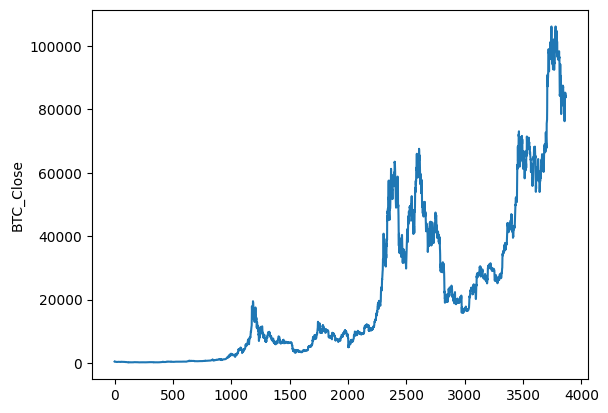

In [14]:
sns.lineplot(data=master['BTC_Close'])

<Axes: ylabel='LTC_Close'>

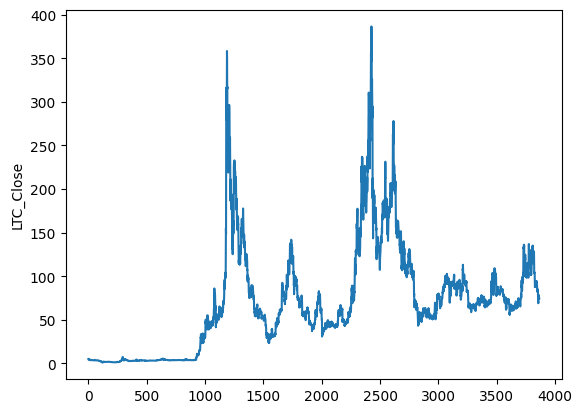

In [15]:
sns.lineplot(data=master['LTC_Close'])

<Axes: ylabel='ETH_Close'>

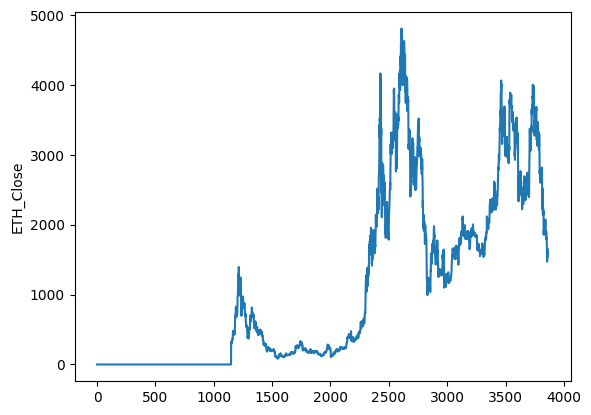

In [16]:
sns.lineplot(data=master['ETH_Close'])

In [17]:
master[['BTC_Close', 'ETH_Close', 'LTC_Close']].corr()

,BTC_Close,ETH_Close,LTC_Close
BTC_Close,1.000000,0.898709,0.548526
ETH_Close,0.898709,1.000000,0.624322
LTC_Close,0.548526,0.624322,1.000000


In [18]:
master['BTC_Return'] = master['BTC_Close'].pct_change()
master['LTC_Return'] = master['LTC_Close'].pct_change()
master['ETH_Return'] = master['ETH_Close'].pct_change()

In [19]:
master[['BTC_Return', 'LTC_Return', 'ETH_Return']] = master[['BTC_Return', 'LTC_Return', 'ETH_Return']].fillna(0)

In [21]:
master[['BTC_Return', 'LTC_Return', 'ETH_Return']].head()

,BTC_Return,LTC_Return,ETH_Return
0,0.000000,0.000000,0.0
1,-0.071926,-0.073800,0.0
2,-0.069843,-0.076295,0.0
3,0.035735,-0.009550,0.0
4,-0.024659,-0.009453,0.0


In [22]:
btc_close = master['BTC_Close']

<Axes: >

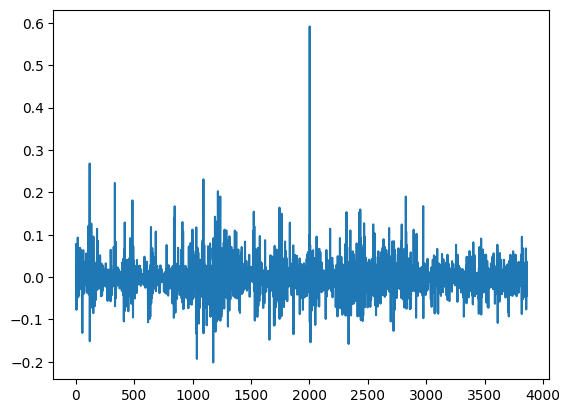

In [23]:
difs = (btc_close.shift() - btc_close) / btc_close
difs = difs.dropna()
difs.plot()

In [24]:
btc_close.shape

(3863,)

# Dickey Fuller Test

In [62]:
result = adfuller(master['BTC_Close'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -0.576898853927101
p-value: 0.8761169690143191
Critical Value (1%): -3.432059428024606
Critical Value (5%): -2.8622953314506385
Critical Value (10%): -2.567172072571461


In [63]:
master['diff1'] = master['BTC_Close'].diff().dropna()

result = adfuller(master['diff1'].dropna())
print('ADF Statistic (1st diff):', result[0])
print('p-value:', result[1])

ADF Statistic (1st diff): -9.230509018594823
p-value: 1.6833555153190045e-15


In [65]:
def check_stationarity(series, title="Original Series"):
    result = adfuller(series.dropna())
    print(f"\n🧪 ADF Test - {title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    
    if result[1] < 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is NOT stationary (fail to reject H0)")


In [66]:
check_stationarity(master['BTC_Close'])


🧪 ADF Test - Original Series
ADF Statistic: -0.5769
p-value: 0.8761
Critical Value (1%): -3.4321
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672
Series is NOT stationary (fail to reject H0)


In [67]:
master['diff1'] = master['BTC_Close'].diff()
check_stationarity(master['diff1'], "1st Order Differenced")


🧪 ADF Test - 1st Order Differenced
ADF Statistic: -9.2305
p-value: 0.0000
Critical Value (1%): -3.4321
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672
Series is stationary (reject H0)


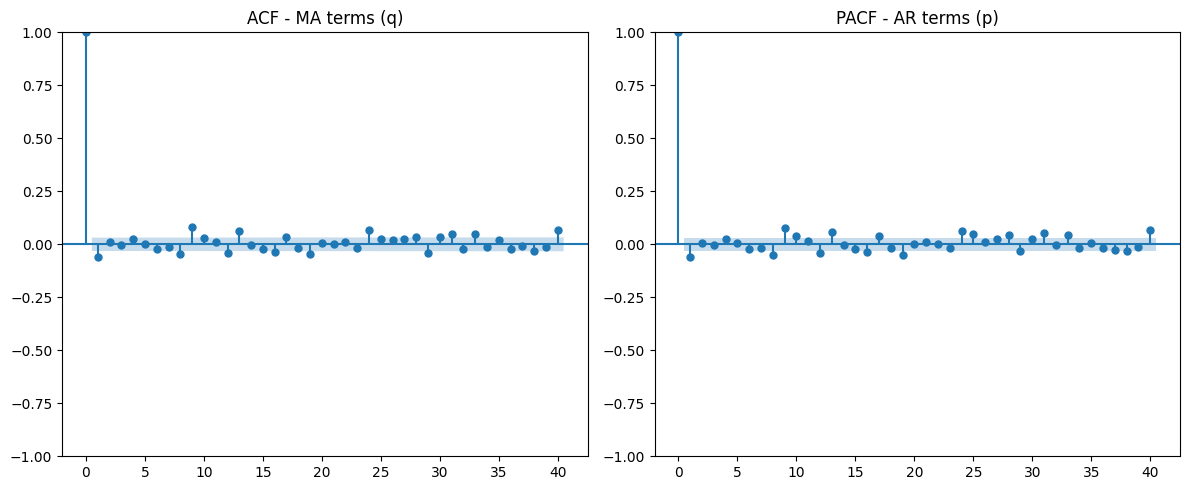

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(master['diff1'].dropna(), ax=plt.gca(), lags=40)
plt.title("ACF - MA terms (q)")

plt.subplot(1, 2, 2)
plot_pacf(master['diff1'].dropna(), ax=plt.gca(), lags=40, method='ywm')
plt.title("PACF - AR terms (p)")
plt.tight_layout()
plt.show()


# ARIMA Model

In [ ]:
btc_close_values = btc_close.values
param_list = [(p, d, q) for p in range(5) for d in range(5) for q in range(5)] 

best_order = None
best_mse = float('inf')

for order in param_list:
    mses = []
    tscv = TimeSeriesSplit(n_splits=100, max_train_size=3*31, test_size=1)

    for train_index, test_index in tscv.split(btc_close_values):
        try:
            train, test = btc_close_values[train_index], btc_close_values[test_index]

            model = sm.tsa.ARIMA(train, order=order)
            result = model.fit()
            prediction = result.forecast(1)[0]

            mse = mean_squared_error(test, [prediction])
            mses.append(mse)

        except Exception as e:
            print(f"Order {order} failed: {e}")

    avg_mse = np.mean(mses) if mses else float('inf')
    print(f"Order {order} → Avg MSE: {avg_mse:.5f}")

    if avg_mse < best_mse:
        best_mse = avg_mse
        best_order = order

print(f"\nBest ARIMA Order: {best_order} with MSE: {best_mse:.5f}")


Order (0, 0, 0) → Avg MSE: 100913186.44550
Order (0, 0, 1) → Avg MSE: 38435304.53237
Order (0, 0, 2) → Avg MSE: 23256317.32432
Order (0, 0, 3) → Avg MSE: 16429192.44521
Order (0, 0, 4) → Avg MSE: 14337563.49106
Order (0, 1, 0) → Avg MSE: 6476532.65443
Order (0, 1, 1) → Avg MSE: 6470348.03902
Order (0, 1, 2) → Avg MSE: 6494625.45759
Order (0, 1, 3) → Avg MSE: 6502983.06286
Order (0, 1, 4) → Avg MSE: 6496919.07846
Order (0, 2, 0) → Avg MSE: 15387862.56940
Order (0, 2, 1) → Avg MSE: 13678378.11894
Order (0, 2, 2) → Avg MSE: 12228768.62041
Order (0, 2, 3) → Avg MSE: 11557343.97009
Order (0, 2, 4) → Avg MSE: 11398361.73265
Order (0, 3, 0) → Avg MSE: 47452334.61651
Order (0, 3, 1) → Avg MSE: 15555429.12723
Order (0, 3, 2) → Avg MSE: 10546111.06775
Order (0, 3, 3) → Avg MSE: 10512994.52527
Order (0, 3, 4) → Avg MSE: 9928295.78599
Order (0, 4, 0) → Avg MSE: 155944547.28603
Order (0, 4, 1) → Avg MSE: 47952661.29351
Order (0, 4, 2) → Avg MSE: 15980813.61438
Order (0, 4, 3) → Avg MSE: 15829130.90

In [141]:
master.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,BTC_Return,LTC_Return,ETH_Return,diff1
Date,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.08589,5.17077,4.96595,5.05855,3071840,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.06543,5.06543,4.57996,4.68523,4569260,0.0,0.0,0.0,0.0,0.0,-0.071926,-0.073800,0.0,-32.894012
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,4.68729,4.75582,4.25435,4.32777,3917450,0.0,0.0,0.0,0.0,0.0,-0.069843,-0.076295,0.0,-29.644012
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,4.32920,4.61608,4.20219,4.28644,5490660,0.0,0.0,0.0,0.0,0.0,0.035735,-0.009550,0.0,14.108002
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,4.26307,4.30013,4.15499,4.24592,2931220,0.0,0.0,0.0,0.0,0.0,-0.024659,-0.009453,0.0,-10.082977


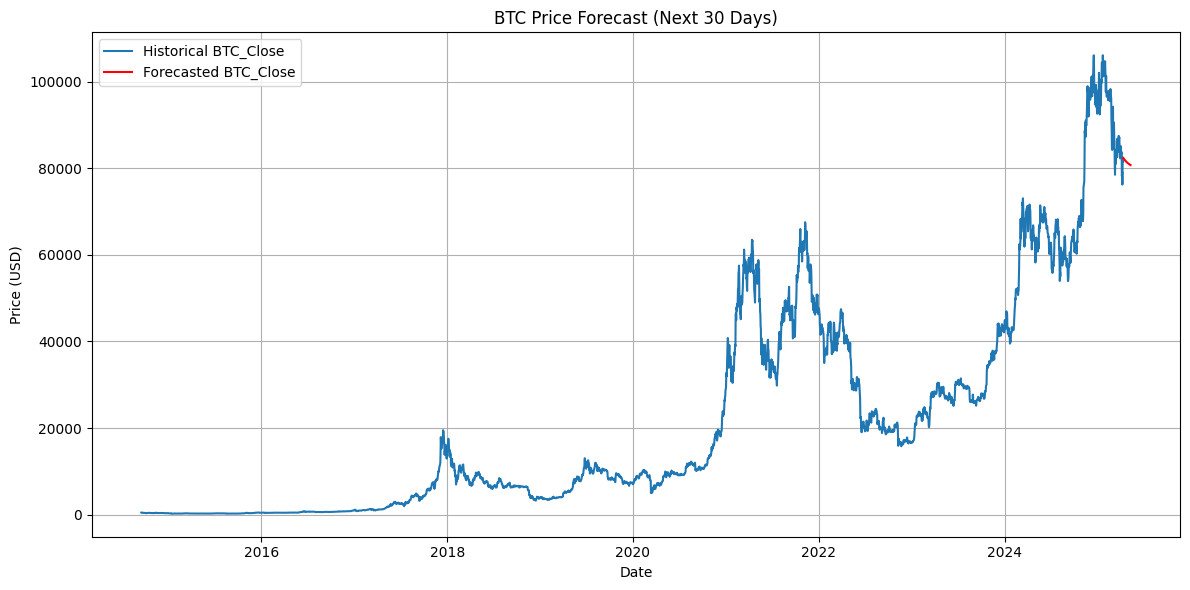

In [152]:
final_order = (2, 1, 3)

# Fit the ARIMA model on the full BTC_Close data
model = sm.tsa.ARIMA(master['BTC_Close'][:-30], order=final_order)
result = model.fit()

forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

last_date = master.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(master['BTC_Close'], label='Historical BTC_Close')
plt.plot(forecast_index, forecast, label='Forecasted BTC_Close', color='red')
plt.title('BTC Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [138]:
# master['Date'] = pd.to_datetime(master['Date'])
# master.set_index('Date', inplace=True)

In [25]:
def evaluate_model(y_true, y_pred, model_name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation")
    print(f"MSE : {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE : {mae}")
    print(f"R²  : {r2}")

In [153]:
actual_arima = master['BTC_Close'][-30:]
evaluate_model(actual_arima, forecast, model_name="ARIMA (Hold-out)")

ARIMA (Hold-out) Evaluation
MSE : 9832043.89355568
RMSE: 3135.60901477778
MAE : 2672.4367630308184
R²  : -0.5105669095047205


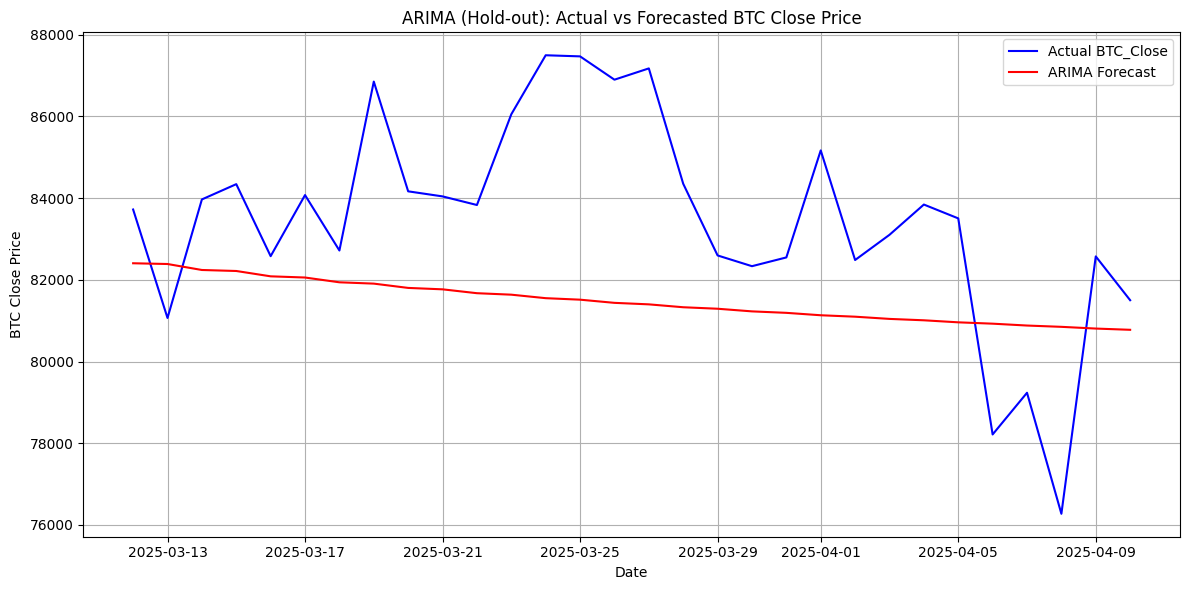

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(actual_arima.index, actual_arima.values, label='Actual BTC_Close', color='blue')
plt.plot(actual_arima.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA (Hold-out): Actual vs Forecasted BTC Close Price')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SARIMAX

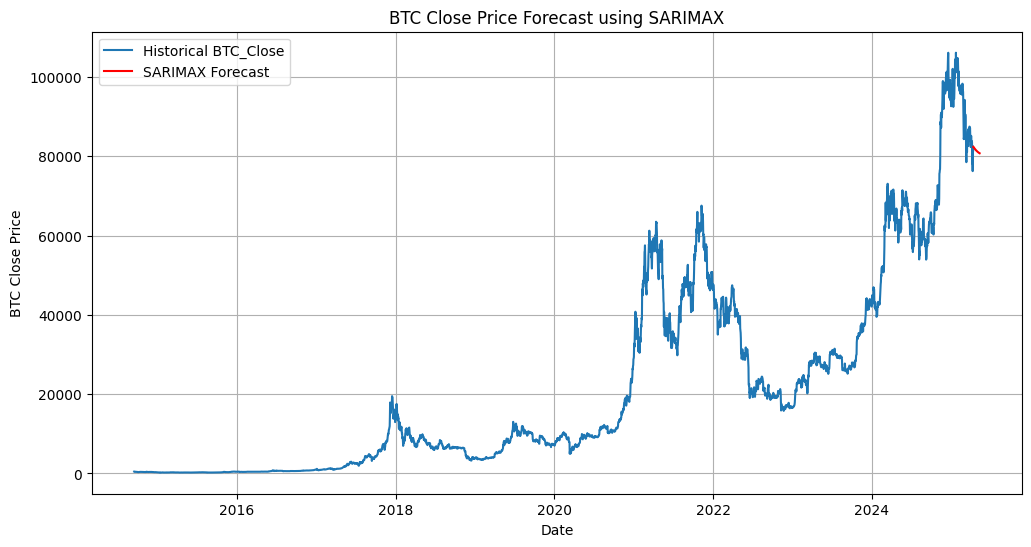

In [157]:
model = SARIMAX(master['BTC_Close'][:-30], order=(2, 1, 3), seasonal_order=(0, 0, 0, 0)) 
result = model.fit(disp=False)

forecast_steps = 30
forecast = result.forecast(steps=forecast_steps)

last_date = master.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(master.index, master['BTC_Close'], label='Historical BTC_Close')
plt.plot(forecast_index, forecast, label='SARIMAX Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.title('BTC Close Price Forecast using SARIMAX')
plt.legend()
plt.grid(True)
plt.show()


In [158]:
actual = master['BTC_Close'][-30:]

# Evaluate SARIMAX
evaluate_model(actual, forecast, model_name="SARIMAX")

SARIMAX Evaluation
MSE : 9832043.89355568
RMSE: 3135.60901477778
MAE : 2672.4367630308184
R²  : -0.5105669095047205


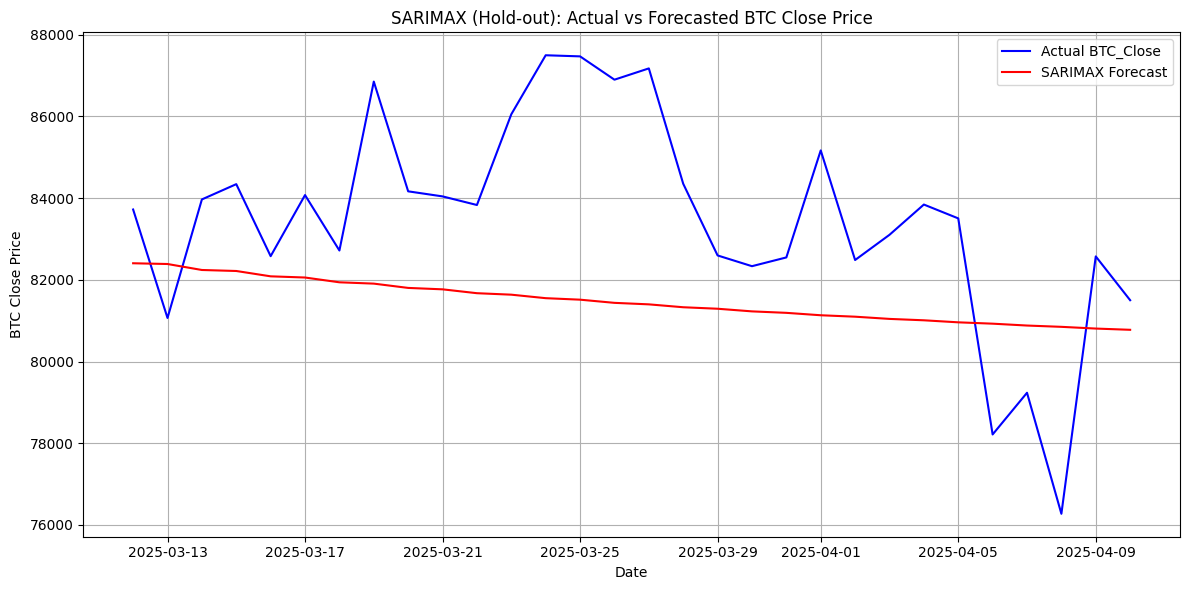

In [159]:
plt.figure(figsize=(12, 6))
plt.plot(actual_arima.index, actual_arima.values, label='Actual BTC_Close', color='blue')
plt.plot(actual_arima.index, forecast, label='SARIMAX Forecast', color='red')
plt.title('SARIMAX (Hold-out): Actual vs Forecasted BTC Close Price')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

In [31]:
btc_close = master[['BTC_Close', 'ETH_Close', 'LTC_Close']].values.reshape(-1, 3)

scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc_close)

In [27]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 60  
X, y = create_sequences(btc_scaled, sequence_length)


In [28]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3042, 60, 3), (3042, 3), (761, 60, 3), (761, 3))

In [30]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 3)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(3)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0160 - val_loss: 9.0808e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 9.3132e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 6.1852e-04
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 5.6351e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 4.5939e-04
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 5.8388e-04
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 4.6366e-04
Epoch 10/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 5.5162e-04
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 6.3132e-04
Epoch 12/20
86/86 ━━━━━━━━━

In [32]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [33]:
mean_squared_error(real_prices, predicted_prices)

5855015.835119908

In [34]:
evaluate_model(y_test, predicted, 'LSTM-1')

LSTM-1 Evaluation
MSE : 0.001874059014018477
RMSE: 0.04329040325543846
MAE : 0.03238417493253288
R²  : 0.545805694852055


In [38]:
real_prices.shape

(761, 3)

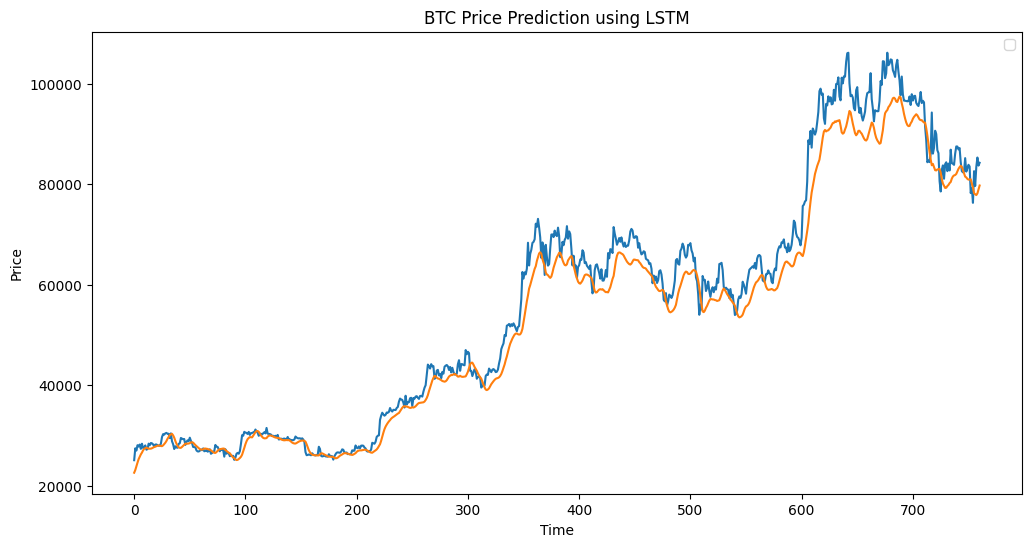

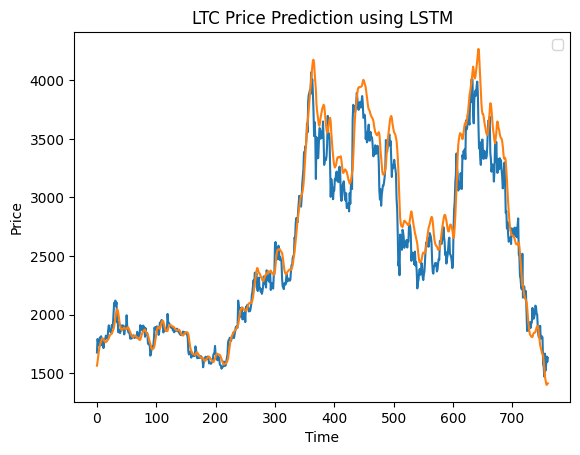

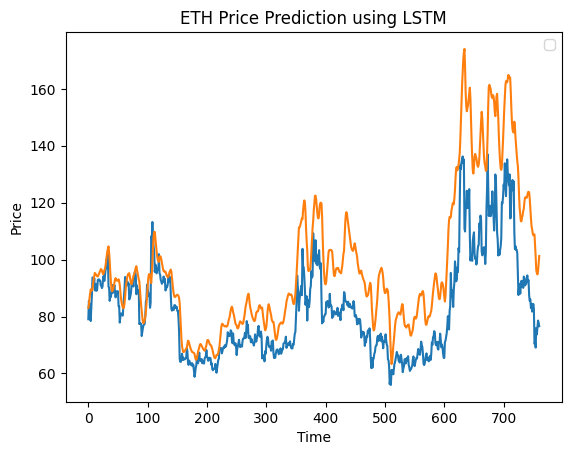

In [40]:
plt.figure(figsize=(12,6))
plt.plot(real_prices[:,0])
plt.plot(predicted_prices[:,0])
plt.title("BTC Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
plt.plot(real_prices[:,1])
plt.plot(predicted_prices[:,1])
plt.title("LTC Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
plt.plot(real_prices[:,2])
plt.plot(predicted_prices[:,2])
plt.title("ETH Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [41]:
window_size = 60
model_list_lstm = [
    [
        LSTM(32, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(units=3)],
    [
        LSTM(64, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(units=3)
    ],
    [
        LSTM(128, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dense(units=3)
    ],
    [
        LSTM(32, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(units=3)
    ],
    [
        LSTM(64, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dense(units=3)
    ],
    [
        LSTM(50, return_sequences=True, input_shape=(window_size, 3)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(units=3)
    ]
]

In [42]:
X_train.shape, window_size

((3042, 60, 3), 60)

In [43]:
best_model = None
best_history = None
best_val_loss = float('inf')
best_index = -1

histories = []

for i, arch in enumerate(model_list_lstm):
    print(f"\n Training model {i+1}/{len(model_list_lstm)}...")

    model = Sequential()
    for layer in arch:
        model.add(layer)

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop]
    )

    val_loss = min(history.history['val_loss'])
    histories.append((model, history))

    print(f" Model {i+1} best val_loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history
        best_index = i

print(f"\n Best model is Model {best_index+1} with val_loss: {best_val_loss:.4f}")



 Training model 1/6...
 Model 1 best val_loss: 0.0003

 Training model 2/6...
 Model 2 best val_loss: 0.0002

 Training model 3/6...
 Model 3 best val_loss: 0.0002

 Training model 4/6...
 Model 4 best val_loss: 0.0005

 Training model 5/6...
 Model 5 best val_loss: 0.0004

 Training model 6/6...
 Model 6 best val_loss: 0.0003

 Best model is Model 3 with val_loss: 0.0002


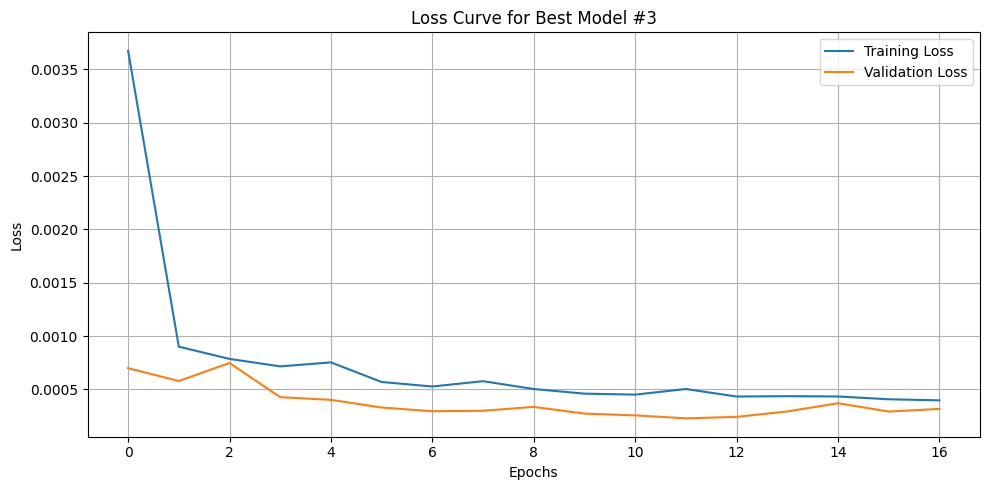

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Best Model #{best_index+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


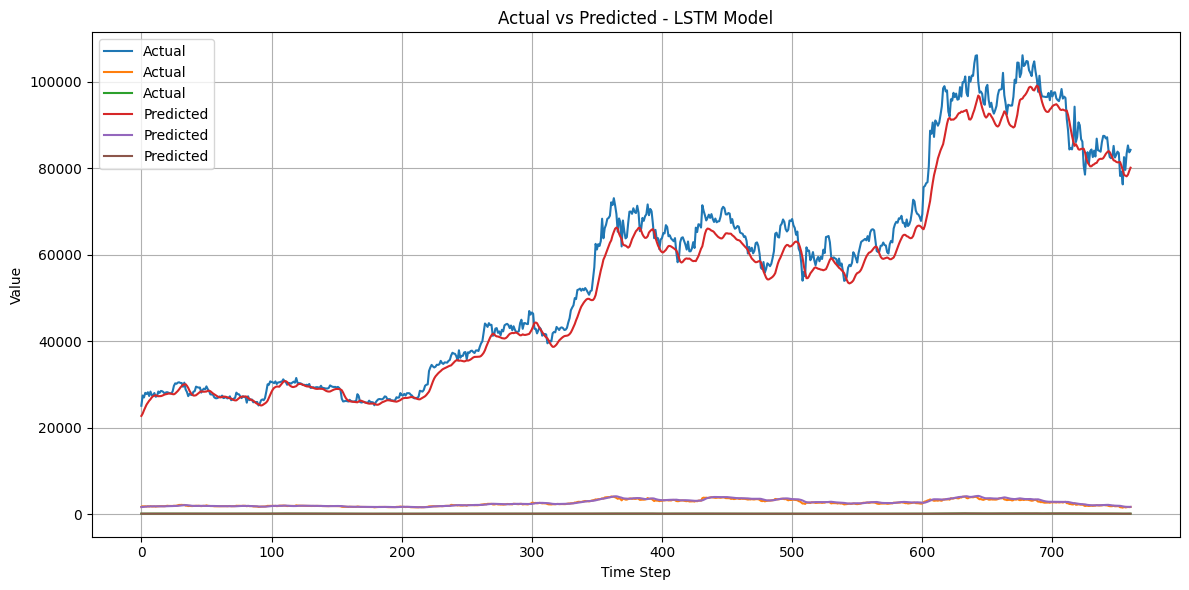

In [45]:
pred = best_model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='Predicted')
plt.title('Actual vs Predicted - LSTM Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
evaluate_model(y_test, pred, 'LSTM-2')

LSTM-2 Evaluation
MSE : 0.000943257733136731
RMSE: 0.030712501251717206
MAE : 0.02066799764987382
R²  : 0.9380558185419998


In [47]:
best_model_2 = None
best_history_2 = None
best_val_loss_2 = float('inf')
best_index_2 = -1

histories_2 = []

for i, arch in enumerate(model_list_lstm):
    print(f"\n Training model {i+1}/{len(model_list_lstm)}...")

    model = Sequential()
    for layer in arch:
        model.add(layer)

    model.compile(optimizer='adam', loss='mean_squared_error')

    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_split=0.1,
        verbose=0
        # callbacks=[early_stop]
    )

    val_loss = min(history.history['val_loss'])
    histories.append((model, history))

    print(f"Model {i+1} best val_loss: {val_loss}")

    if val_loss < best_val_loss_2:
        best_val_loss_2 = val_loss
        best_model_2 = model
        best_history_2 = history
        best_index_2 = i

print(f"\n Best model is Model {best_index_2+1} with val_loss: {best_val_loss_2}")



 Training model 1/6...
Model 1 best val_loss: 0.0002774997556116432

 Training model 2/6...
Model 2 best val_loss: 0.0001759840379236266

 Training model 3/6...
Model 3 best val_loss: 0.00014404323883354664

 Training model 4/6...
Model 4 best val_loss: 0.0004176682559773326

 Training model 5/6...
Model 5 best val_loss: 0.0002791219740174711

 Training model 6/6...
Model 6 best val_loss: 0.00022231096227187663

 Best model is Model 3 with val_loss: 0.00014404323883354664


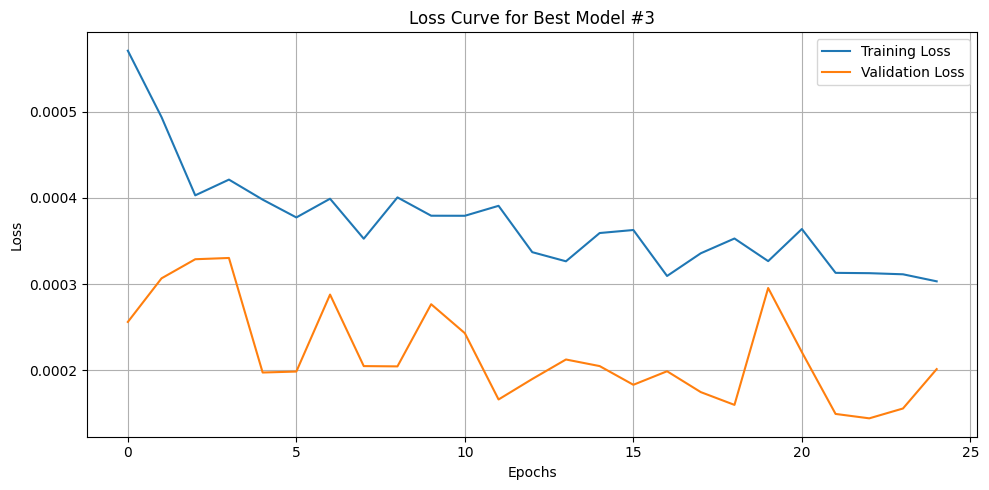

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(best_history_2.history['loss'], label='Training Loss')
plt.plot(best_history_2.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Best Model #{best_index_2+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


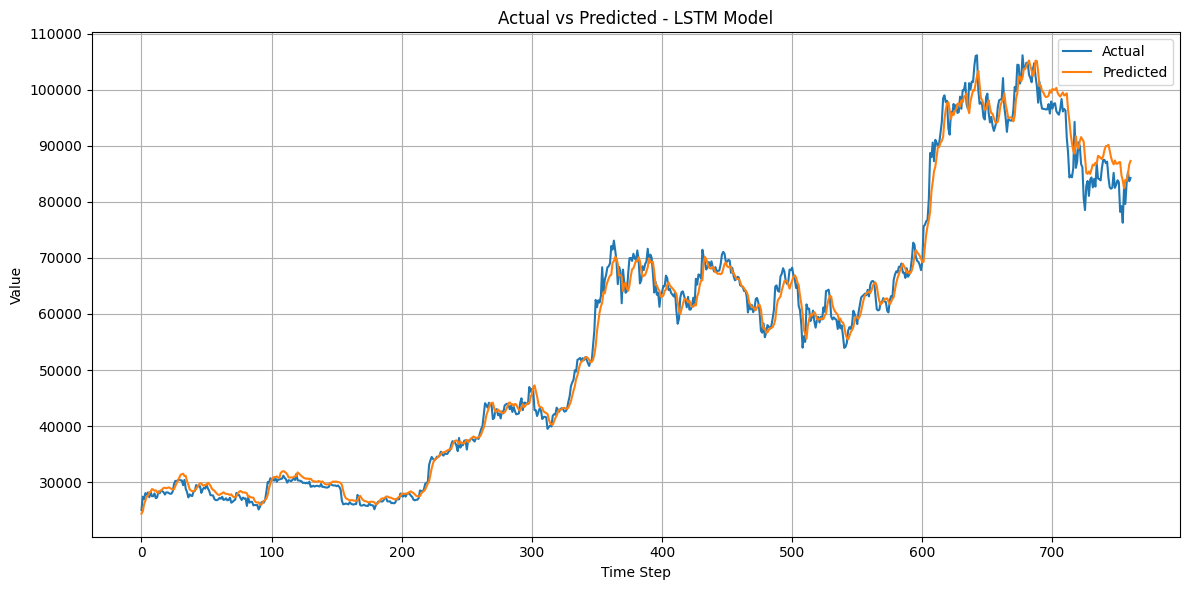

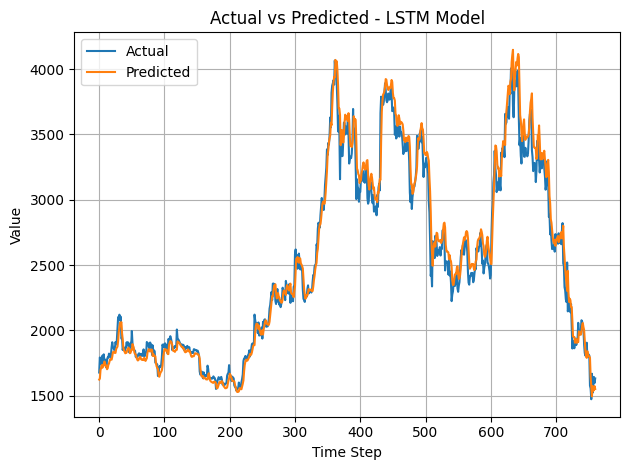

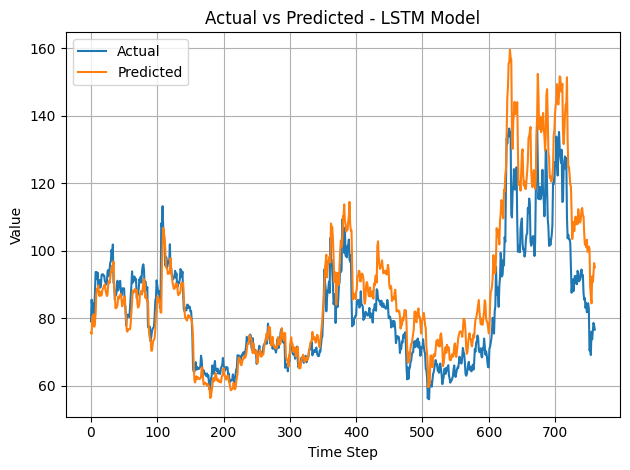

In [51]:
pred = best_model_2.predict(X_test)
pred_inv = scaler.inverse_transform(pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:,0], label='Actual')
plt.plot(pred_inv[:,0], label='Predicted')
plt.title('Actual vs Predicted - LSTM Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.plot(y_test_inv[:,1], label='Actual')
plt.plot(pred_inv[:,1], label='Predicted')
plt.title('Actual vs Predicted - LSTM Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.plot(y_test_inv[:,2], label='Actual')
plt.plot(pred_inv[:,2], label='Predicted')
plt.title('Actual vs Predicted - LSTM Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
evaluate_model(y_test, pred, "LSTM-3")

LSTM-3 Evaluation
MSE : 0.0005844614489133659
RMSE: 0.02417563750789968
MAE : 0.017266962430083643
R²  : 0.8619803800716205


# Prophet

In [185]:
master.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,BTC_Return,LTC_Return,ETH_Return,diff1
Date,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.08589,5.17077,4.96595,5.05855,3071840,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.06543,5.06543,4.57996,4.68523,4569260,0.0,0.0,0.0,0.0,0.0,-0.071926,-0.073800,0.0,-32.894012
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,4.68729,4.75582,4.25435,4.32777,3917450,0.0,0.0,0.0,0.0,0.0,-0.069843,-0.076295,0.0,-29.644012
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,4.32920,4.61608,4.20219,4.28644,5490660,0.0,0.0,0.0,0.0,0.0,0.035735,-0.009550,0.0,14.108002
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,4.26307,4.30013,4.15499,4.24592,2931220,0.0,0.0,0.0,0.0,0.0,-0.024659,-0.009453,0.0,-10.082977


In [194]:
master.shape

(3859, 19)

In [195]:
3859-365

3494

In [213]:
prophet_df = master.copy()
prophet_df = prophet_df.reset_index() 
prophet_df.rename(columns={'Date': 'ds', 'BTC_Close': 'y'}, inplace=True)

prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.date

model = Prophet(daily_seasonality=True) 
model.fit(prophet_df)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

23:56:21 - cmdstanpy - INFO - Chain [1] start processing
23:56:22 - cmdstanpy - INFO - Chain [1] done processing


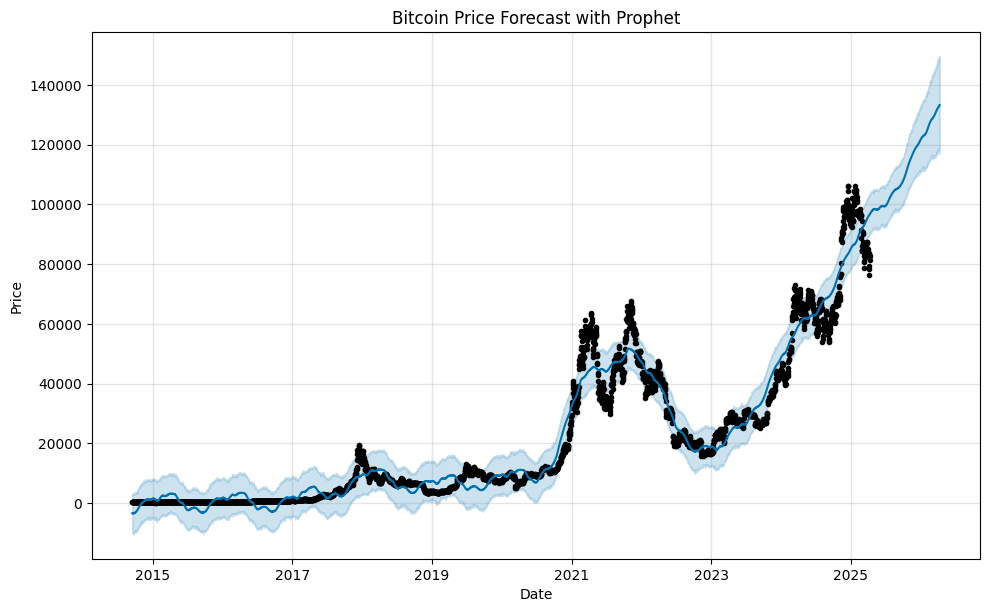

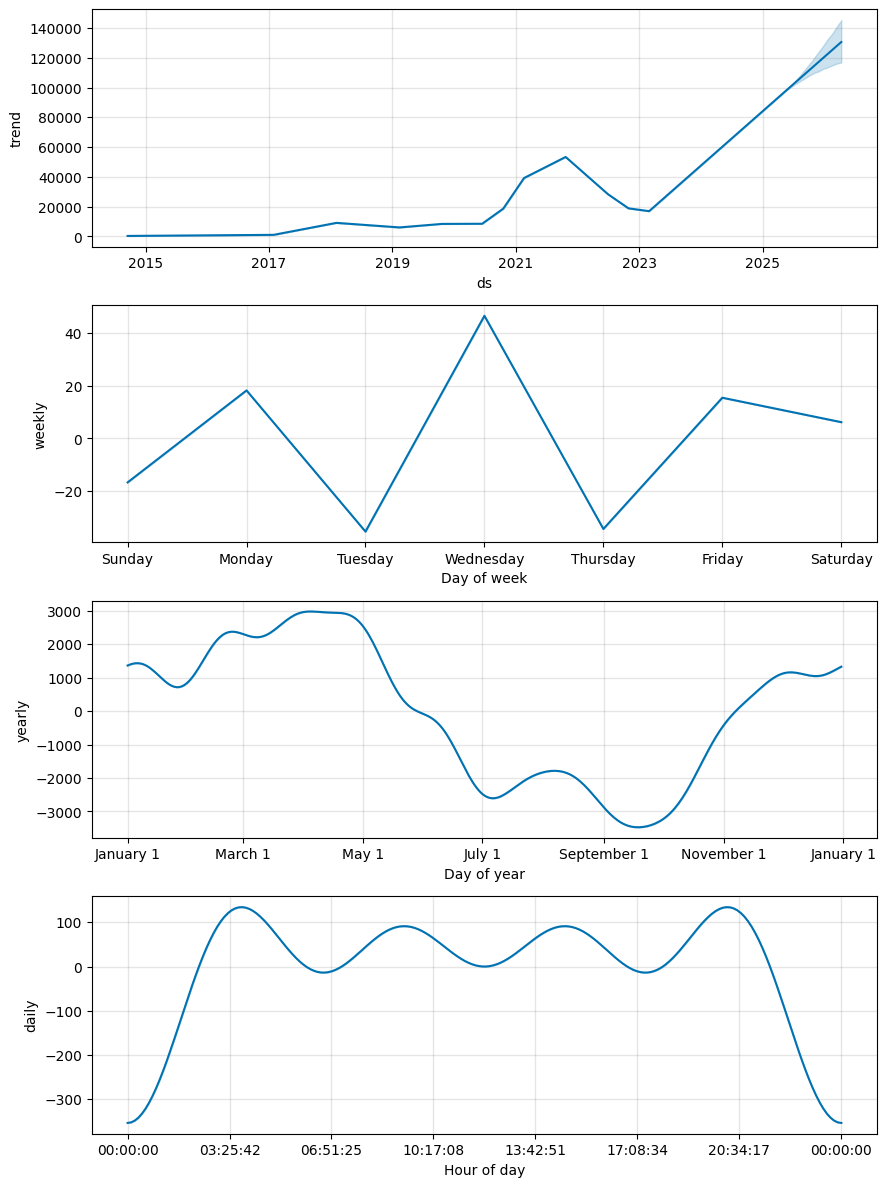

In [214]:
model.plot(forecast)
plt.title('Bitcoin Price Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

model.plot_components(forecast)
plt.show()

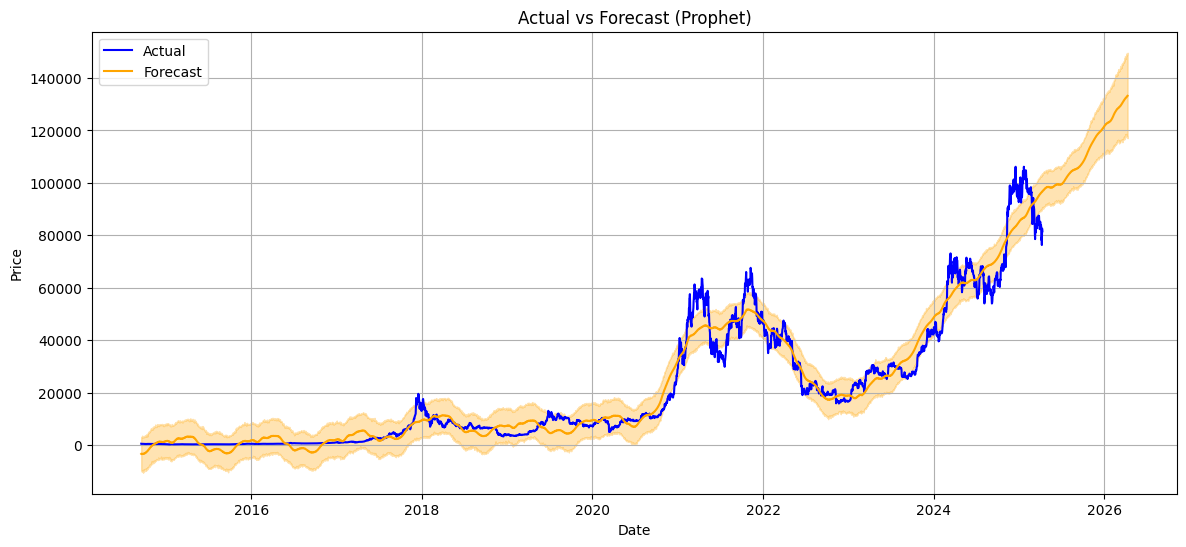

In [215]:
plt.figure(figsize=(14, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.title('Actual vs Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
The LSTM model outperforms among the other models for Bitcoin cryptocurrency. Assumiing that I get similar results for the other two cryptocurrencies. I would sugget that the LSTM model be selected for deployment purposes.